# TUNED DECISION TREE MODEL
## Implementing a decision tree model to run on WHO data.

#### I created this model to see if the results that it provides can provide useful insights, and to make predictions based on the data.

#### This model produces a confusion matrix, visual decision tree and feature importance plot.

#### It then re-executes the model utilizing hyperparameter tuning. The results of the hyperparameter tuning, with accompanying confusion matrix, visual decision tree and feature importance plot are produced.

#### The F1, recall, precision and accurarcy scores, which are in the range of 0.8190 - 0.8352, are lower than what would be desirable. In general, the goal would be to find a model that scored in the mid-90s for the four scores. (This is the case with the tuned random forest and tuned XGBoost models run on the same data. You can see the details of those models in their respective jpynb files.)
<br>

Best Avg. Validation Score:  0.8181

| Model        |   F1     |  Recall  | Precision |Accuracy |
|:-------------|:--------:|:--------:|:---------:|--------:|
|Tuned Decision Tree | 0.818081 | 0.818966 | 0.835193 | 0.818966|
<br>

The confusion matrix shows that the model is able to predict 'High' and 'Low' life expectancies with a good level of accuracy. It also indicates that the three most important features in predicting the outcome, in order of importance, are:

  1. Probability of dying from any of CVD, cancer, diabetes, CRD between age 30 and exact age 70 (%)_nan
  2. Mortality rate attributed to exposure to unsafe WASH services (per 100 000 population)_SEX_BTSX
  3. Diphtheria-tetanus-pertussis (DTP3) immunization coverage among 1-year-olds (%)_nan

These outcomes suggest that cardiovascular diseas, cancer, diabetes and chronic respiratory disease are highly tied to life expectancy, and focusing health policy on these areas would be most effective in improving life expectancy. It also indicates that targeting WASH services (water, sanitation and hygiene), along with DTP immunizations, could also have a measurable impact. These are areas where an important benefit (e.g. life expectancy) can be obtained with a reasonable amount of resources, since it is a situation where a modest investment in proven and established programs and technologies can result in tremendous rewards, in the form of higher life expectancy.

In [62]:
###################
# IMPORT PACKAGES #
###################

import numpy as np
import pandas as pd
import pickle as pkl
import csv
import time

# Important imports for modeling and evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import sklearn.metrics as metrics

# Visualization package imports
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
###############
# THE DATASET #
###############

# Import the data
WHO_data = pd.read_csv('web_download_data_WHO.csv')

# Display the first 10 rows of data
WHO_data.head(10)

,IND_NAME,DIM_GEO_NAME,IND_CODE,DIM_GEO_CODE,DIM_TIME_YEAR,DIM_1_CODE,VALUE_NUMERIC,VALUE_STRING,VALUE_COMMENTS
0,Adolescent birth rate (per 1000 women),Afghanistan,MDG_0000000003,AFG,2021,AGEGROUP_YEARS15-19,62.000000,62.0,Afghanistan 2022-2023 Multiple Indicator Clust...
1,Adolescent birth rate (per 1000 women),Afghanistan,MDG_0000000003,AFG,2021,AGEGROUP_YEARS10-14,18.000000,18.0,Afghanistan 2022-2023 Multiple Indicator Clust...
2,Age-standardized mortality rate attributed to ...,Afghanistan,SDGAIRBODA,AFG,2019,SEX_BTSX,265.664520,265.7,NaN
3,Age-standardized prevalence of hypertension am...,Afghanistan,NCD_HYP_PREVALENCE_A,AFG,2019,SEX_BTSX,40.200001,40.2,NaN
4,Age-standardized prevalence of obesity among a...,Afghanistan,NCD_BMI_30A,AFG,2022,SEX_BTSX,19.222589,19.2,NaN
5,Age-standardized prevalence of tobacco use amo...,Afghanistan,M_Est_tob_curr_std,AFG,2022,SEX_BTSX,22.700001,22.7,The most recent survey was conducted in 2019. ...
6,Amount of water- and sanitation-related offici...,Afghanistan,SDGODAWS,AFG,2022,NaN,67.955803,67.96,NaN
7,Annual mean concentrations of fine particulate...,Afghanistan,SDGPM25,AFG,2019,NaN,75.187180,75.2,NaN
8,Average of 15 International Health Regulations...,Afghanistan,SDGIHR2021,AFG,2023,NaN,38.066700,38,NaN
9,Density of dentists (per 10 000 population),Afghanistan,HWF_0010,AFG,2019,NaN,0.714000,0.7,Includes Dentists Stock Total. Data source: WH...


In [64]:
############################################
# EXPLORATORY DATA ANALYSIS / DATA SHAPING #
############################################

# Display the data type for each column
WHO_data.dtypes

# Pivot dataframe to create columns based on IND_NAME
WHO_data_pivot = WHO_data.pivot(index=['DIM_GEO_NAME'],
                        columns=['IND_NAME','DIM_1_CODE'], values='VALUE_NUMERIC')

WHO_data = WHO_data_pivot.reset_index()

# Flatten multi-index pivot into dataframe
WHO_data.columns = WHO_data.columns.to_flat_index()
WHO_data.columns = ['_'.join(str(col) for col in multi_col) for multi_col in WHO_data.columns]

# Import CSV file as dictionary, used to rename long column names
def csv_to_dict_no_header(filename):
    """Imports a two-column CSV file into a dictionary.

    Args:
        filename (str): The filename of the CSV file.

    Returns:
        dict: A dictionary where the first column is the key and the second is the value.
    """
    data_dict = {}
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
           if row:  # Ensure the row is not empty
                key = row[0]
                value = row[1]
                data_dict[key] = value
    return data_dict

filename = 'WHO_data_1_columns_dict.csv'
data_as_dict = csv_to_dict_no_header(filename)

WHO_data.rename(columns=data_as_dict, inplace=True)

# Create 'Life_expectancy_category' column
condition1 = (WHO_data['Life_expect_at_brth_yrs_BTSX'] <= 65)
condition2 = ((WHO_data['Life_expect_at_brth_yrs_BTSX'] > 65)
  & (WHO_data['Life_expect_at_brth_yrs_BTSX'] <= 75))
condition3 = (WHO_data['Life_expect_at_brth_yrs_BTSX'] > 75)

value1 = 'Low'
value2 = 'Medium'
value3 = 'High'
defaultvalue = 'NaN'

WHO_data['Life_expectancy_category'] = np.select([condition1, condition2,
                                               condition3],
                                                [value1, value2, value3],
                                              default=defaultvalue)

WHO_data = WHO_data.fillna(0)

# Remove records with Life_expectancy_category == NaN
WHO_data = WHO_data[WHO_data['Life_expectancy_category'] != 'NaN']

# Drop column Life_expect_at_brth_yrs_BTSX, used in creating Life_expectancy_category
WHO_data = WHO_data.drop(columns=['Life_expect_at_brth_yrs_BTSX'])

# Output unique values
print('Display unique values:')
display(WHO_data['Life_expectancy_category'].unique())

# Check the class balance using the counts of predicted labels
print('\nDisplay counts of predicted labels:')
display(WHO_data['Life_expectancy_category'].value_counts(dropna=False))

# Check for missing values
print('\nDisplay missing values:')
display(WHO_data.isna().sum())

# Check for the number of rows and columns in the dataset
print('\nDisplay the number of rows and columns in the dataset:')
display(WHO_data.shape)

# Drop columns with high correlation to target variable to remove impact on feature importance
WHO_data = WHO_data.drop(columns=['Life_expect_at_brth_yrs_MLE',
                       'Life_expect_at_brth_yrs_FMLE',
                       'Healthy_life_expect_at_birth_yrs_BTSX',
                       'Healthy_life_expect_at_birth_yrs_MLE',
                       'Healthy_life_expect_at_birth_yrs_FMLE'],
              )

Display unique values:


array(['Low', 'High', 'Medium'], dtype=object)


Display counts of predicted labels:


,count
Life_expectancy_category,
Medium,98
High,55
Low,39



Display missing values:


,0
DIM_GEO_NAME_,0
Adlcnt_birth_rate_per1k_wm_agrp_yr_15_19,0
Adlcnt_birth_rate_per1k_wm_agrp_yr_10_14,0
Age_std_mort_rt_hhold_ambnt_air_poltn_100K_BTSX,0
Age_std_prev_hyptsn_adlts_age_30-79_yr_pct_BTSX,0
...,...
Pct_tot_antbtc_csmpt_frm_AWaRe_Accs_antbc_cat_pct,0
Cnct_cov_trtmt_srv_drug_use_disodr_pct,0
Prop_hlth_fact_cor_relv_esntl_med_avail_affrd_sust_bsis_pct,0
Pct_15yr_grls_rcvd_rcmmd_dose_HPV_vac_FMLE,0



Display the number of rows and columns in the dataset:


(192, 66)

In [65]:
#####################
# MODEL PREPARATION #
#####################

# Convert the object predictor variable to numerical dummies.
WHO_data_pred_dummies = pd.get_dummies(WHO_data, columns=['DIM_GEO_NAME_'], dtype=int)

# Convert the target variable using label encoding
label_encoder = LabelEncoder()
WHO_data_target_dummies = label_encoder.fit_transform(WHO_data['Life_expectancy_category'])

# Check the column datatypes
print('\nDisplay the column datatypes:')
display(WHO_data_pred_dummies.dtypes)

# Define the y (target) variable.
y = WHO_data_target_dummies

# Define the X (predictor) variables.
X = WHO_data_pred_dummies.drop(columns=['Life_expectancy_category'])

# Split the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


Display the column datatypes:


,0
Adlcnt_birth_rate_per1k_wm_agrp_yr_15_19,float64
Adlcnt_birth_rate_per1k_wm_agrp_yr_10_14,float64
Age_std_mort_rt_hhold_ambnt_air_poltn_100K_BTSX,float64
Age_std_prev_hyptsn_adlts_age_30-79_yr_pct_BTSX,float64
Age_std_prev_obsty_adlts_18pls_yr_pct_BTSX,float64
...,...
DIM_GEO_NAME__Western Pacific Region,int64
DIM_GEO_NAME__Yemen,int64
DIM_GEO_NAME__Zambia,int64
DIM_GEO_NAME__Zimbabwe,int64


In [66]:
#####################
# MODEL PREPARATION #
#####################

# Fit a decision tree classifier model to the data
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
dt_pred = decision_tree.predict(X_test)

Decision Tree Metrics
Accuracy: 0.937500
Precision: 0.937500
Recall: 0.937500
F1 Score: 0.937500




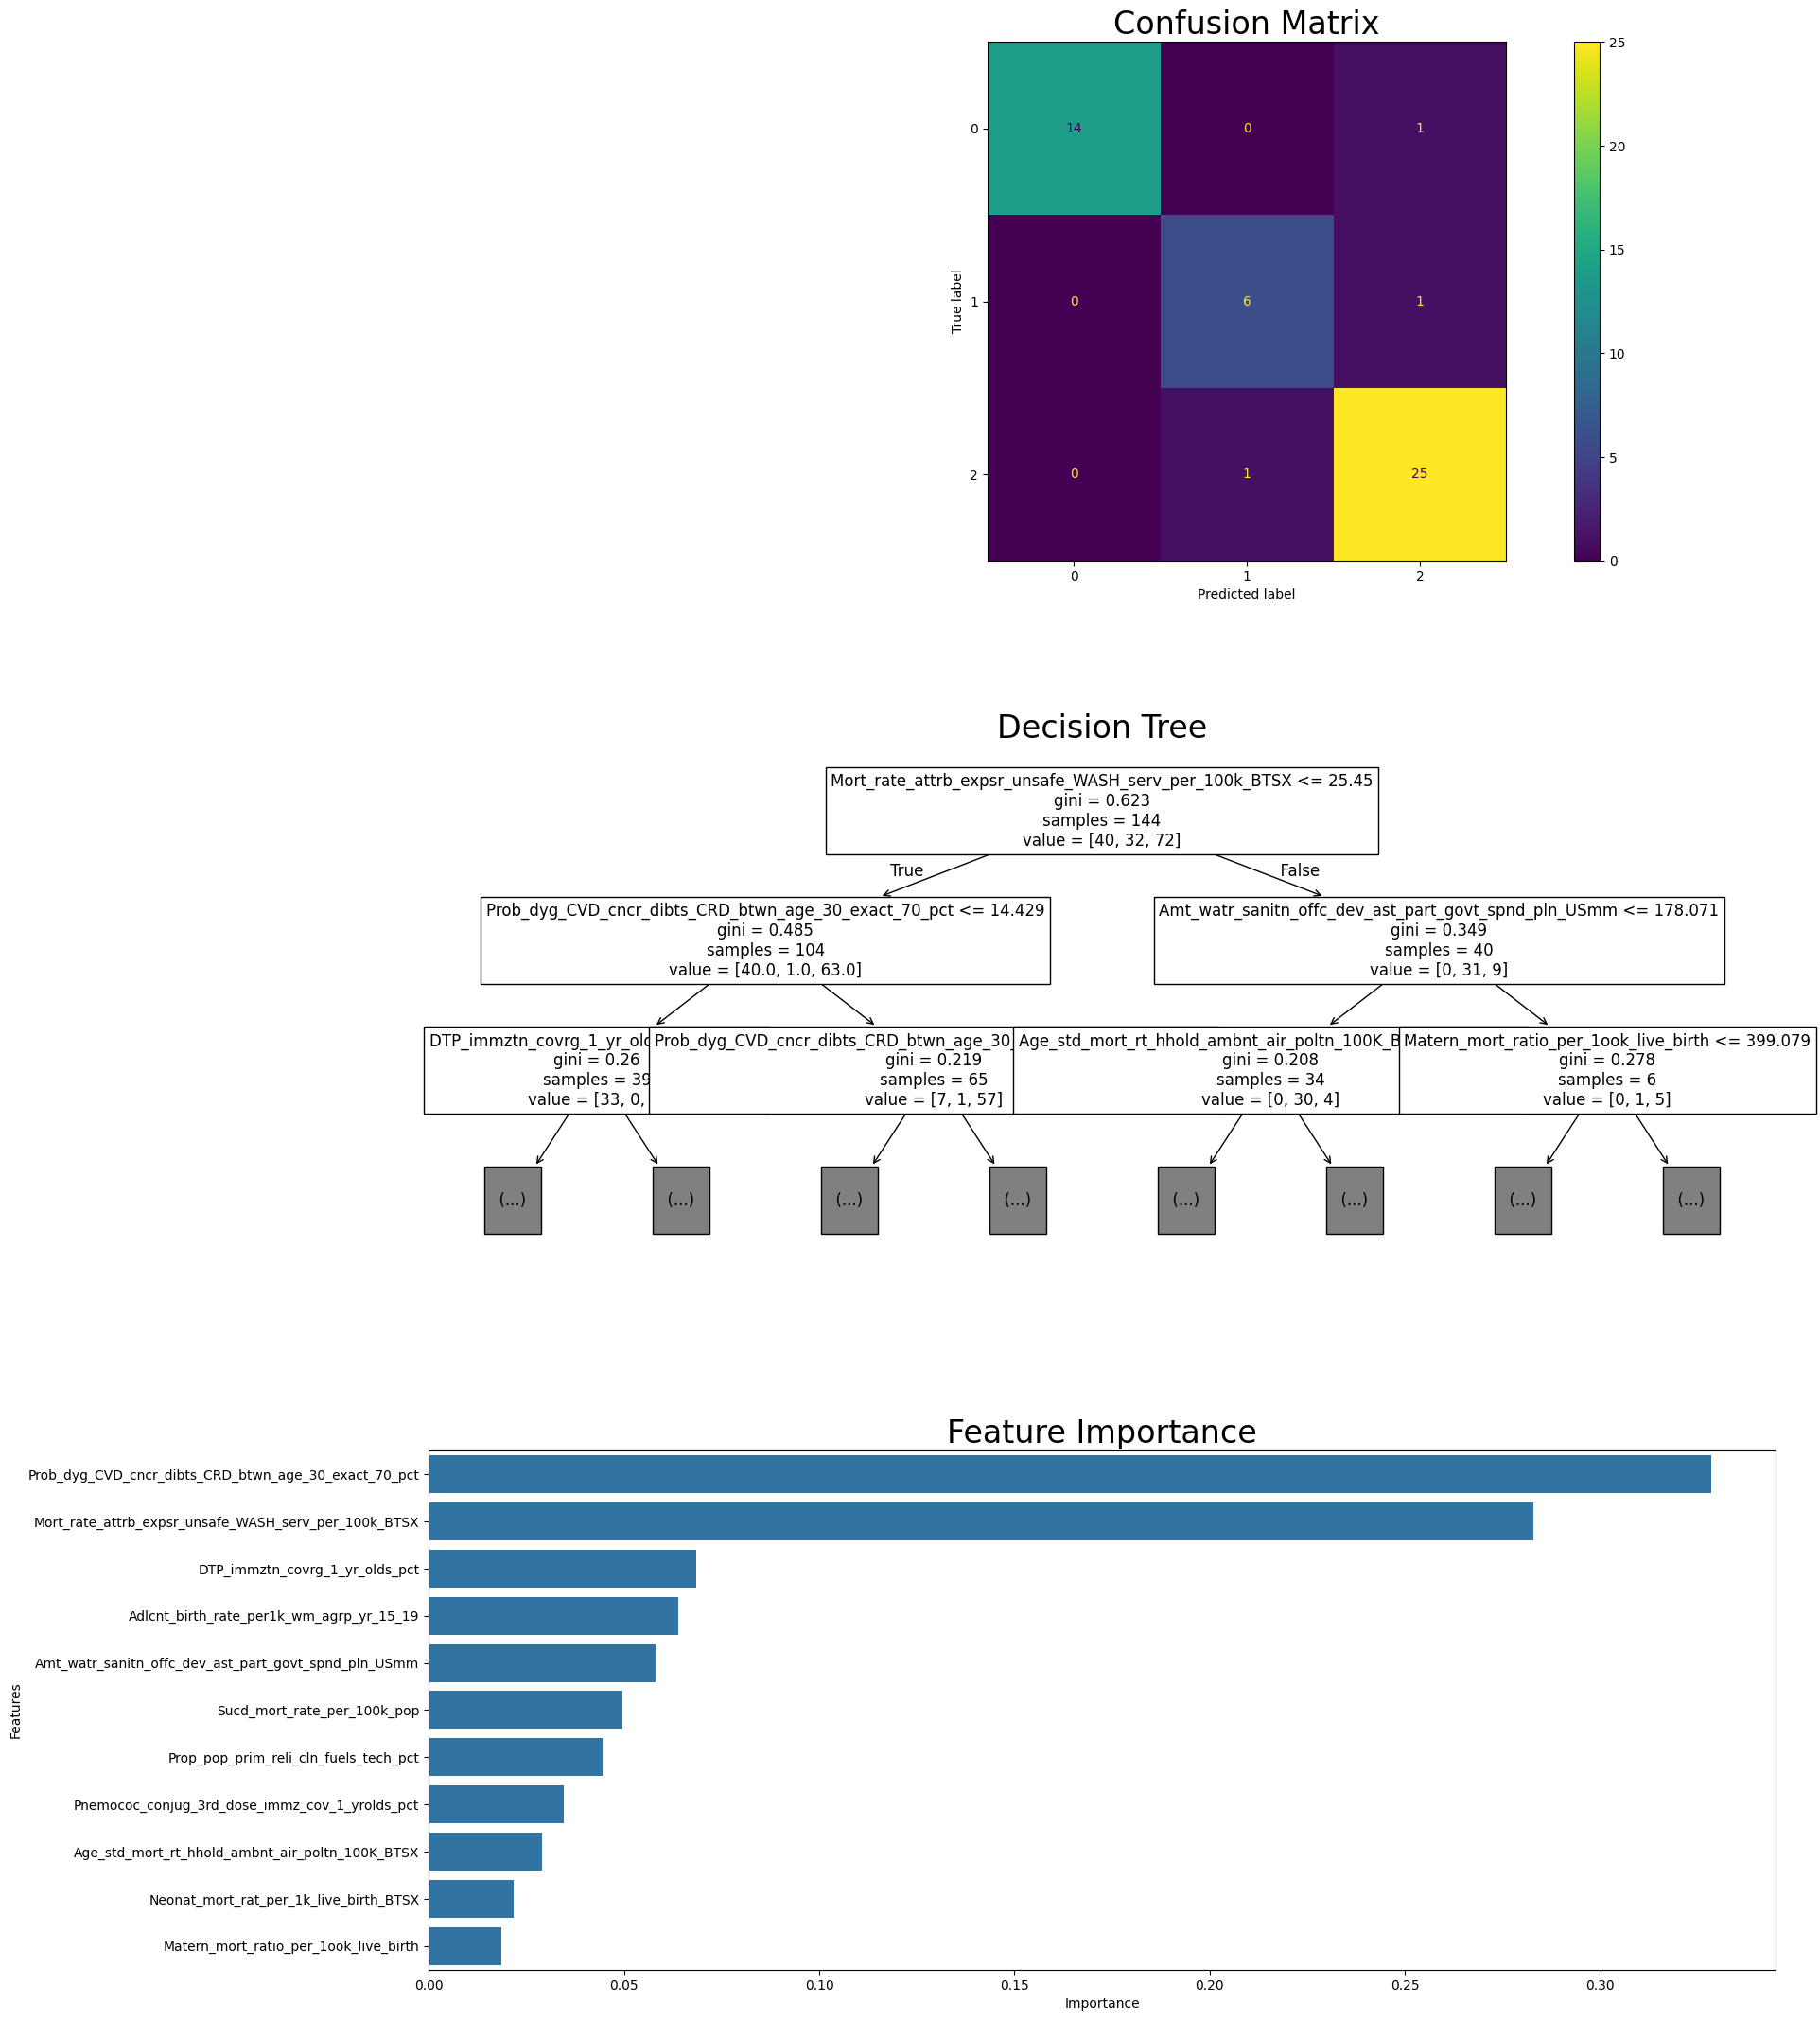

In [67]:
##########################
# RESULTS AND EVALUATION #
##########################

# Display the decision tree model's accuracy, precision, recall, and F1 score.
print("Decision Tree Metrics")
print("Accuracy:", "%.6f" % metrics.accuracy_score(y_test, dt_pred))
print("Precision:", "%.6f" % metrics.precision_score(y_test, dt_pred, average='micro'))
print("Recall:", "%.6f" % metrics.recall_score(y_test, dt_pred, average='micro'))
print("F1 Score:", "%.6f" % metrics.f1_score(y_test, dt_pred, average='micro'))

# Create a figure with two subplots
# (one for the confusion matrix and one for the decision tree)
fig, axes = plt.subplots(3, 1, figsize=(18, 24))
#plt.subplots_adjust(wspace=3, hspace=5)
plt.tight_layout(pad=12)

# Produce a confusion matrix
cm = metrics.confusion_matrix(y_test, dt_pred, labels=decision_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=decision_tree.classes_)
print('\n')
axes[0].set_title('Confusion Matrix', fontsize=24)
disp.plot(ax=axes[0])

# Plot the decision tree
plot_tree(decision_tree, ax=axes[1], max_depth=2, fontsize=12, feature_names=X.columns)
axes[1].set_title('Decision Tree', fontsize=24)

# Calculate feature importance
importances = decision_tree.feature_importances_
importances_names = X_train.columns

# Exclude features with importance > 0
#threshold = 0
important_features_mask = importances > 0
filtered_importances = importances[important_features_mask]
filtered_names = importances_names[important_features_mask]
sorted_indices = np.argsort(filtered_importances)[::-1]
sorted_filtered_importances = filtered_importances[sorted_indices]
sorted_filtered_names = filtered_names[sorted_indices]

# Plot feature importance
sns.barplot(x=sorted_filtered_importances, y=sorted_filtered_names, orient='h', ax=axes[2])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance', fontsize=24)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


Best Avg. Validation Score:  0.8181 

                 Model        F1    Recall  Precision  Accuracy
0  Tuned Decision Tree  0.818081  0.818966   0.835193  0.818966



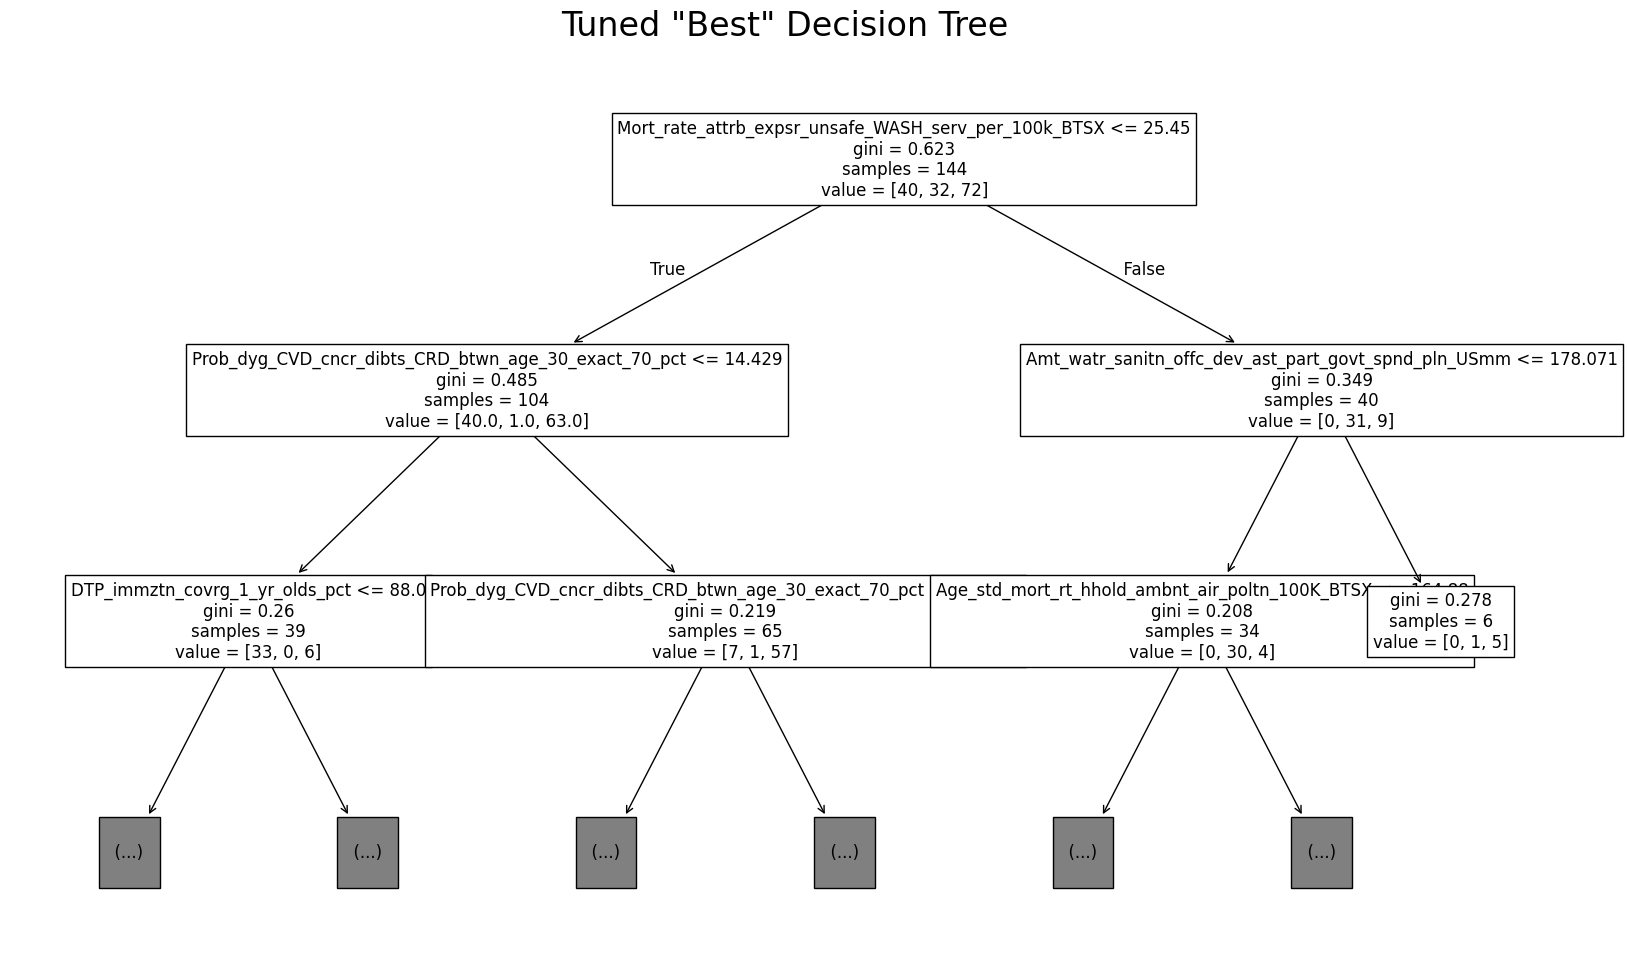

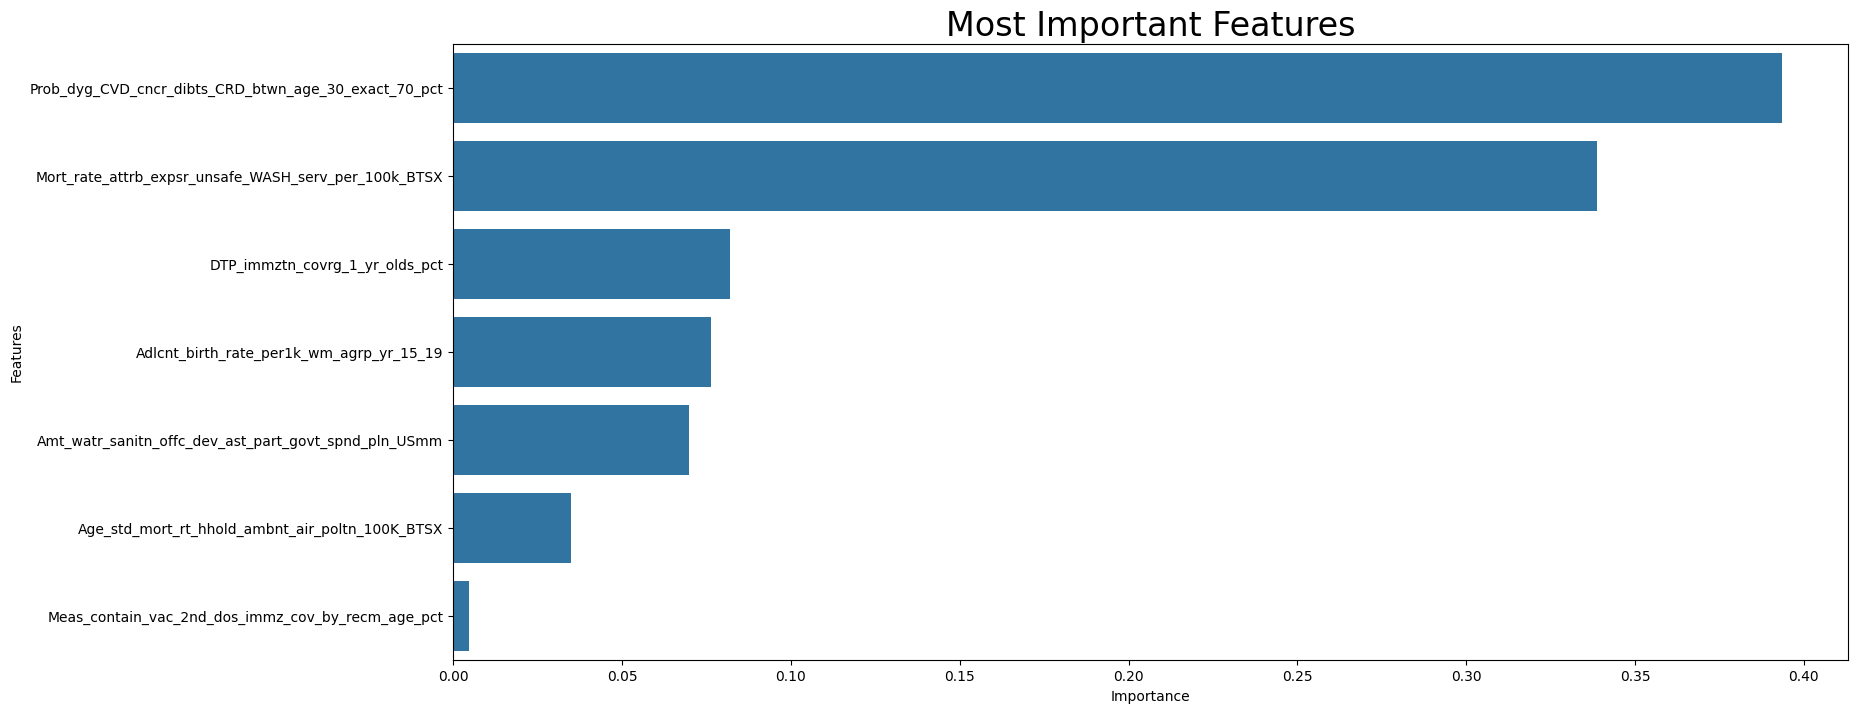

In [68]:
from ctypes import c_void_p
#########################
# HYPERPARAMETER TUNING #
#########################

# Hyperparameter values
tree_para = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50],
              'min_samples_leaf': [2,3,4,5,6,7,8,9, 10, 15, 20, 50]}
scoring = {'accuracy': 'accuracy', 'precision': 'precision_weighted',
           'recall': 'recall_weighted', 'f1': 'f1_weighted'}

# Check combination of values
tuned_decision_tree = DecisionTreeClassifier(random_state=42)
clf = GridSearchCV(tuned_decision_tree,
                   tree_para,
                   scoring = scoring,
                   cv=5,
                   refit="f1")
clf.fit(X_train, y_train)

# Compute the best combination of values for the hyperparameters
clf.best_estimator_

time.sleep(2)

# Determine the best average validation score
print("\nBest Avg. Validation Score: ", "%.4f" % clf.best_score_,'\n')

# Determine the "best" decision tree model's accuracy, precision, recall, and F1 score

def make_results(model_name, model_object):
  '''
  Accepts as arguments a model name (your choice - string) and
  a fit GridSearchCV model object.

  Returns a pandas df with the F1, recall, precision, and accuracy scores
  for the model with the best mean F1 score across all validation folds.
  '''

  # Get all the results from the CV and put them in a df.
  cv_results = pd.DataFrame(model_object.cv_results_)

  # Isolate the row of the df with the max (mean F1 score).
  best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

  # Extract accuracy, precision, recall, F1 score from that row.
  f1 = best_estimator_results.mean_test_f1
  precision = best_estimator_results.mean_test_precision
  recall = best_estimator_results.mean_test_recall
  accuracy = best_estimator_results.mean_test_accuracy

  # Create table of results
  table = pd.DataFrame({'Model': model_name,
                        'F1': [f1],
                        'Recall': [recall],
                        'Precision': [precision],
                        'Accuracy': [accuracy]
                        }
                       )

  return table

result_table = make_results('Tuned Decision Tree', clf)
print(f'{result_table}\n')

# Plot the "best" decision tree
plt.figure(figsize=(20, 12))
plot_tree(clf.best_estimator_, max_depth=2, fontsize=12, feature_names=X.columns)
plt.title('Tuned "Best" Decision Tree', fontsize=24)
plt.show()

# Feature importance graph to validate most important features
importances = clf.best_estimator_.feature_importances_
importances_names = clf.best_estimator_.feature_names_in_

# Exclude features with importance > 0
threshold = 0
important_features_mask = importances > threshold
filtered_importances = importances[important_features_mask]
filtered_names = importances_names[important_features_mask]
sorted_indices = np.argsort(filtered_importances)[::-1]
sorted_filtered_importances = filtered_importances[sorted_indices]
sorted_filtered_names = filtered_names[sorted_indices]

# Plot feature importance
fig, ax = plt.subplots(figsize=(18, 8)) # Create a new figure and axes
sns.barplot(x=sorted_filtered_importances, y=sorted_filtered_names, orient='h', ax=ax)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Most Important Features', fontsize=24)
plt.show()